# Bayesian inference for differentiable agent-based models with variational inference

In this tutorial, we will discuss how model gradients - provided by implementing agent-based models (ABMs) in differentiable programming languages - can help with certain calibration and optimisation tasks. In particular, we will use the [blackbirds](https://github.com/arnauqb/blackbirds) package [1] to calibrate an ABM using generalised variational inference (GVI). 
Let's start by providing a short introduction to GVI. Given an ABM with parameters $\theta$, observed data $y$, a prior distribution $\pi$ over the parameters, a loss function $\ell$ that captures the discrepancy between the behaviour of the ABM at parameter values $\theta$ and data $y$, and a positive real hyperparameter $w > 0$, the goal of GVI is to approximate the generalised posterior distribution 

$$
\pi(\theta|y) \propto \exp(-\ell(\theta, y)/w)\pi(\theta) 
$$

with a simpler distribution $q_\phi(\theta)$, which is parameterized by parameters $\phi$. The choice $\ell(\theta, y) = - \log p(y | \theta)$ and $w = 1$ corresponds to classical Bayesian inference.

We can define the best fitting distribution $q_\phi^*(\theta)$ as the one with parameters $\phi^*$ that minimises the Kullback-Leibler divergence $D$ from $q_\phi(\theta)$ to $\pi(\theta|y)$.

Then, the optimal $q_\phi^*$ is given by 

$$
q_\phi^*(\theta) = \arg\min_\phi \left\{ \mathbb E_{q_\phi(\theta)} \left[ \ell (\theta, y)/w \right] + D(q_\phi || \pi) \right\}.
$$

Luckily, we do not need to worry too much about the details of the optimization process, as the `blackbirds` package takes care of that for us. We only need to provide the ABM (implemented in PyTorch, potentially with suitably defined surrogate gradients), the observed data, and the prior distribution over the parameters. Let's see how this works in practice.


In [1]:
#!pip install blackbirds

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from blackbirds.infer.vi import VI

# 2. Simple example: Bayesian inference for a Bernoulli random walk model

In the previous tutorial we implemented a differentiable random walk model with discrete steps. We reimplement this below:

In [3]:
def random_walk(theta, n_timesteps, tau=0.5):
    x = torch.tensor([0.0])
    for i in range(n_timesteps - 1):
        logits = torch.hstack((theta, 1 - theta)).log()
        xi = torch.nn.functional.gumbel_softmax(logits, tau=tau, hard=True)[0]
        next_x = x[-1] + 2 * xi - 1
        x = torch.hstack((x, next_x))
    return x

Let's generate some synthetic data and use the `blackbirds` package to calibrate the model.

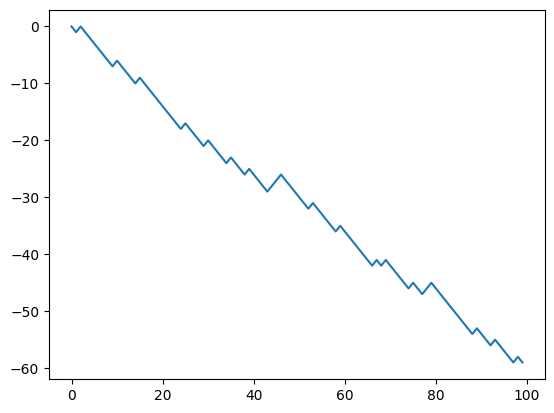

In [4]:
# Generate synthetic data
n_timesteps = 100
theta_true = torch.tensor([0.2])
x_true = random_walk(theta_true, n_timesteps)
fig, ax = plt.subplots()
ax.plot(x_true, label='True')

We will use a Beta prior over $\theta$.

In [5]:
beta_shape_1 = torch.tensor(2.)
beta_shape_2 = torch.tensor(2.)
prior = torch.distributions.Beta(beta_shape_1, beta_shape_2)

Now we need to choose a variational family for $q$. We will use another distribution with trainable shape parameters.

In [6]:
class TrainableBeta(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.par_1 = torch.nn.Parameter(torch.ones(1)*2)
        self.par_2 = torch.nn.Parameter(torch.ones(1)*2)

    def sample(self, n):
        dist = torch.distributions.Beta(self.par_1, self.par_2)
        theta = dist.rsample((n,))
        logprob = dist.log_prob(theta)
        return theta, logprob

Now we need to specify the loss $\ell(\theta, y)$. In this example, we know the likelihood function for the model, and know that a Beta prior is conjugate for Bernoulli distribution in the context of the classical posterior (i.e., when taking $\ell(\theta, y) = - \log p(y | \theta)$). We will therefore use this, since it will allow us to check the accuracy of the variational posterior:

In [7]:
def diffed_clamped(y):
    y_diffed = y.diff()
    y_diffed_clamped = (y_diffed + 1.) / 2.
    return y_diffed_clamped

def loss(theta, y):
    y_diffed_clamped = diffed_clamped(y)
    log_prob = torch.distributions.Binomial(len(y_diffed_clamped), theta).log_prob(y_diffed_clamped.sum())
    return -log_prob.squeeze()

And we have all the ingredients!

In [ ]:
q = TrainableBeta()
optimizer = torch.optim.Adam(q.parameters(), lr=1e-2)
vi = VI(loss,
    posterior_estimator=q,
    prior=prior,
    optimizer=optimizer,
    w = 1, # this is a relative weight between the loss and the KL term,
    n_samples_per_epoch=500
    )
vi.run(x_true, n_epochs=2500, max_epochs_without_improvement=500)

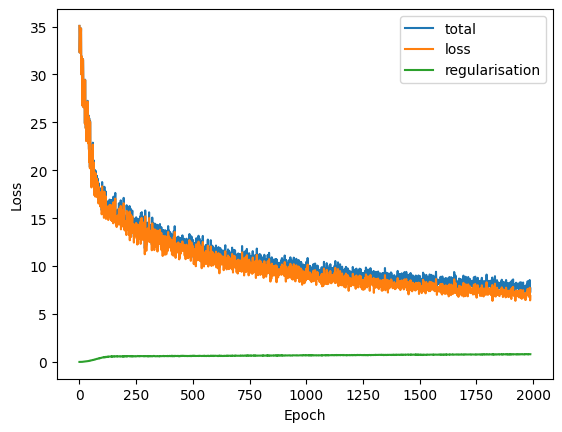

In [9]:
# we can now inspect the loss
loss_df = pd.DataFrame(vi.losses_hist)
loss_df.plot(xlabel='Epoch', ylabel='Loss');

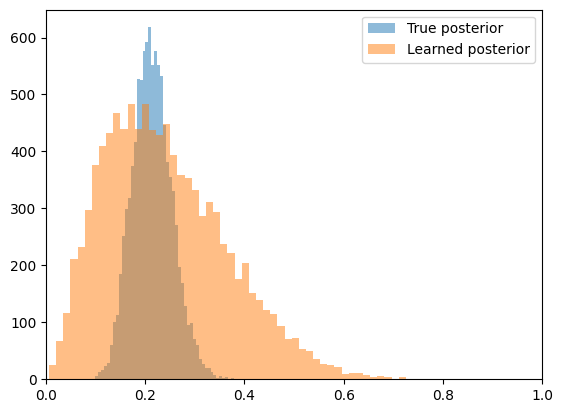

In [10]:
# and we can check the trained posterior

n_samples = 10_000
x_true_diffed_clamped = diffed_clamped(x_true)
n_draws = len(x_true_diffed_clamped)
variational_posterior_samples = q.sample(n_samples)[0].detach().numpy()
true_posterior_samples = torch.distributions.Beta(beta_shape_1 + x_true_diffed_clamped.sum(),
                                                  beta_shape_2 + n_draws - x_true_diffed_clamped.sum()
                                                ).sample((n_samples,)).numpy()

fig, ax = plt.subplots()
ax.hist(true_posterior_samples, bins=50, alpha=0.5, label='True posterior')
ax.hist(variational_posterior_samples, bins=50, alpha=0.5, label='Learned posterior')
ax.legend();
ax.set_xlim([0,1]);

We could improve upon this approximation by running the optimisation procedure for longer.

# 3. More complicated example: ABM of clustered volatility in financial markets

We now consider a second more complicated example, which we take from our ICAIF 2023 paper on "Gradient-assisted calibration for financial agent-based models" (Dyer et al., 2023). (Further experiments from this paper available in [this repository](https://github.com/joelnmdyer/gradient_assisted_calibration_abm/tree/main).)

In this model, a collection of $N$ agents trade a single asset over time steps $t = 1, \ldots, T$, where the price of the asset at time $t$ is written $S_t$. At time $t$, agent $i$ submits an order, which can take on three different possible values; buy and sell are represented with $\rho_i(t) = 1$ and $−1$, respectively; $\rho_i(t) = 0$ means that agent $i$ is inactive at this time. 

Agent $i$ decides whether or not to place an order at time $t$ using the rule:

$$
    \rho_i(t) = \mathbb{I}_{\epsilon_t > \nu_i(t)} - \mathbb{I}_{\epsilon_t < -\nu_i(t)},
$$

where $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ is a common signal received by each agent that forecasts the next time period’s log-returns, 

$$
    r_t = \log S_t / S_{t - 1},
$$

in the price of the asset. In the above, $\nu_i(t) > 0$ is the threshold level for agent $i$ at time $t$, which determines the range of values of the public information $\epsilon_t$ that agent $i$ considers to be significant. The initial values $\nu_i(0)$ are drawn iid from some probability density function $f_\gamma$ with parameters $\gamma$. 

The actual log-returns is then given by

\begin{equation}\label{eq:logret}
    r_t = \frac{\sum_{i=1}^N \rho_i(t)}{N\eta},
\end{equation}

where $\eta > 0$ is a free parameter of the model. Finally, each agent updates their threshold $\nu_i(t)$ at time $t$ according to

\begin{equation}\label{eq:nu}
    \nu_i(t) = \mathbb{I}_{u_i(t) < 1/10} \vert{r_t}\vert + \mathbb{I}_{u_i(t) \geq 1/10} \nu_i(t-1),
\end{equation}

where $u_i(t)$ are iid uniformly distributed random variables on the unit interval $[0,1]$.

In the above, there are two instances of discrete randomness, with different characteristics:

- one in the definition of the $\rho_i(t)$, which all depend on a common random variable $\epsilon_t$;
- one in the definition of $\nu_i(t)$.

To build a differentiable implementation of this model, we need to have a way to pass gradients through these operations. We will need to do this in different ways for each of these, since one of them depends on a shared random variable $\epsilon_t$ while the other does not.

The below is a differentiable implementation of this model, using the Gumbel softmax (Jang et al., 2016) and straight-through (Bengio et al., 2013) surrogate gradient tricks we've encountereed previously:

In [11]:
from blackbirds.models.model import Model

class RamaCont(Model):
    def __init__(self, n_agents, n_timesteps, s, sigmoid_k):
        r"""
        Implementation of the Rama Cont model from Rama Cont (2005).

        **Arguments:**

        - `n_agents`: Number of agents
        - `n_timesteps`: Number of timesteps
        - `s`: Probability of updating the threshold $\nu_i$.
        - `sigmoid_k`: Steepness of the sigmoid function.
        """
        super().__init__()
        self.n_agents = n_agents
        self.n_timesteps = n_timesteps
        self.s = s
        self.sigmoid_k = sigmoid_k

    def initialize(self, params):
        nu_0 = torch.distributions.LogNormal(params[0], params[1]).rsample(
            (self.n_agents,)
        )
        epsilon_t = torch.zeros(self.n_agents)
        order = self.compute_order(epsilon_t, nu_0)
        eta = params[3]
        returns = self.compute_returns(order, eta) * torch.ones(self.n_agents)
        x = torch.vstack((nu_0, epsilon_t, returns))
        return x.reshape(1, 3, self.n_agents)

    def step(self, params, x):
        # draw epsilon_t from normal distribution
        sigma = params[2]
        epsilon_t = torch.distributions.Normal(0, sigma).rsample()
        # compute order
        nu_t = x[-1, 0, :]
        order = self.compute_order(epsilon_t, nu_t)
        # compute returns
        eta = params[3]
        returns = self.compute_returns(order, eta)
        # update nu_t
        new_nu_t = self.compute_new_nu_t(nu_t, self.s, returns)
        x = torch.vstack(
            (
                new_nu_t,
                epsilon_t * torch.ones(self.n_agents),
                returns * torch.ones(self.n_agents),
            )
        )
        return x.reshape(1, 3, self.n_agents)

    def observe(self, x):
        return [x[:, 2, 0]]

    def compute_order_soft(self, epsilon_t, nu_t):
        return torch.sigmoid(self.sigmoid_k * (epsilon_t - nu_t)) - torch.sigmoid(
            self.sigmoid_k * (-nu_t - epsilon_t)
        )

    def compute_order_hard(self, epsilon_t, nu_t):
        return (epsilon_t > nu_t).float() - (epsilon_t < -nu_t).float()

    def compute_order(self, epsilon_t, nu_t):
        """
        We do a trick similar to the gumbel-softmax.
        """
        soft = self.compute_order_soft(epsilon_t, nu_t)
        return self.compute_order_hard(epsilon_t, nu_t) + soft - soft.detach() # Straight-through surrogate gradient

    def compute_returns(self, order, eta):
        return 1.0 / (self.n_agents * eta) * order.sum()

    def compute_new_nu_t(self, nu_t, s, returns):
        probs = s * torch.ones(self.n_agents)
        probs = torch.vstack((probs, 1.0 - probs)).transpose(0, 1)
        q = torch.nn.functional.gumbel_softmax(probs.log(), tau=0.1, hard=True)[:, 0] # Gumbel softmax surrogate gradient
        return torch.abs(returns) * q + (1 - q) * nu_t

    def trim_time_series(self, x):
        return x

# Parameterise with the log10 of parameters, to make parameter space unbounded
class LogModel(RamaCont):
    def initialize(self, params):
        return super().initialize(10 ** params)
    def step(self, params, x):
        return super().step(10 ** params, x)

In [12]:
model = LogModel(n_agents = 1000, n_timesteps=100, s=0.1, sigmoid_k=5.0)

We use as loss the maximum mean discrepancy between the empirical and simulated distributions of log-returns: 

In [13]:
from blackbirds.losses import SingleOutput_SimulateAndMMD

In [14]:
class MMDLoss:
    def __init__(self, *args, offset=0., **kwargs):
        self.mmd_calculator = SingleOutput_SimulateAndMMD(*args, **kwargs)
        self.offset = offset
        
    def __call__(self, *args, **kwargs):
        loss = self.mmd_calculator(*args, **kwargs)
        return loss - self.offset

Now we generate the "true" data set:

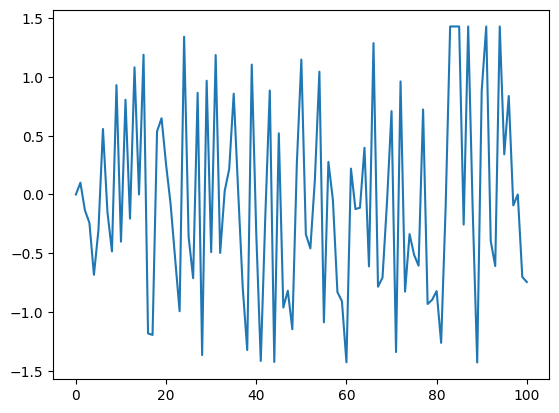

In [17]:
true_parameters = torch.log10(torch.tensor([1., 0.5, 1., .7]))
true_data = model.run_and_observe(true_parameters)
plt.plot(true_data[0]);

We take the variational family in this case to be a normalising flow (a flexible class of neural density estimators):

In [18]:
#!pip install normflows

In [19]:
import normflows as nf

def make_flow():
    torch.manual_seed(1)
    base = nf.distributions.base.DiagGaussian(len(true_parameters))
    num_layers = 5
    latent_size = len(true_parameters)
    flows = []
    for i in range(num_layers):
        param_map = nf.nets.MLP([2, 50, 50, latent_size], init_zeros=True)
        flows.append(nf.flows.AffineCouplingBlock(param_map))
        flows.append(nf.flows.Permute(latent_size, mode='swap'))
    return nf.NormalizingFlow(base, flows)

Finally, taking a multivariate Normal prior, we can find a posterior corresponding to this choice of loss and model:

In [20]:
# Define prior density
prior = torch.distributions.MultivariateNormal(torch.zeros(4), 1.0 * torch.eye(len(true_parameters)))
# Instantiate q_{\phi}
path_estimator = make_flow()
torch.manual_seed(1)
mmd_loss = MMDLoss(model=model, y=true_data[0], offset=1.)
optimizer = torch.optim.AdamW(path_estimator.parameters(), lr=1e-3)
# Optimise
vi = VI(loss=mmd_loss, 
        posterior_estimator=path_estimator, 
        prior=prior, 
        optimizer=optimizer, 
        n_samples_per_epoch=10,
        w=0.001,
        log_tensorboard=True,
        gradient_estimation_method="pathwise",
        gradient_clipping_norm=1.0)
vi.run(true_data[0], n_epochs=100, max_epochs_without_improvement=100);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s, loss=-.992, reg.=0.00772, total=-.984, best loss=-.994, epochs since improv.=14]


We can then, e.g., look at the posterior:

In [21]:
path_estimator.load_state_dict(vi.best_estimator_state_dict)
with torch.no_grad():
    log_posterior_density_of_true_parameters = path_estimator.log_prob(true_parameters.unsqueeze(0))
    print(log_posterior_density_of_true_parameters)
    path_samples = path_estimator.sample(10000)[0].detach().numpy()
samples_prior = prior.sample((10000,)).numpy()

tensor([1.4796])


In [22]:
#!pip install pygtc

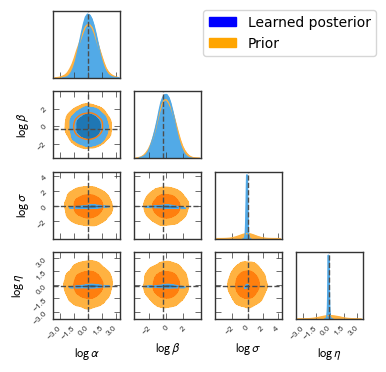

In [23]:
try:
    import pygtc
    pygtc.plotGTC([path_samples, samples_prior],
                  figureSize=4, truths = true_parameters.numpy(), 
                  chainLabels = ["Learned posterior", "Prior", ], 
                  paramNames = [r"$\log\alpha$", r"$\log\beta$", r"$\log\sigma$", r"$\log\eta$"],
                  colorsOrder=['blues', 'oranges']);
except AttributeError:
    import matplotlib.patches as mpatches
    path_patch = mpatches.Patch(color='blue', label='Learned posterior')
    prior_patch = mpatches.Patch(color='orange', label='Prior')
    plt.gcf().legend(handles=[path_patch, prior_patch], loc='upper right', bbox_to_anchor=(.95,0.9))

# References

[1] Quera-Bofarull, A., Dyer, J., Calinescu, A., Farmer, J. D., & Wooldridge, M. (2023). BlackBIRDS: Black-Box Inference foR Differentiable Simulators. Journal of Open Source Software, 8(89).

[2] Dyer, Joel, et al. "Gradient-assisted calibration for financial agent-based models." Proceedings of the Fourth ACM International Conference on AI in Finance. 2023.

[3] Bengio, Yoshua, Nicholas Léonard, and Aaron Courville. "Estimating or propagating gradients through stochastic neurons for conditional computation." arXiv preprint arXiv:1308.3432 (2013).

[4] Jang, Eric, Shixiang Gu, and Ben Poole. "Categorical reparameterization with gumbel-softmax." arXiv preprint arXiv:1611.01144 (2016).